In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math

In [3]:
def func(x):
    return 2*x**2 + 4*x -2

In [4]:
func(4)

46

In [5]:
# Plot a graph of the function
x_vals = np.arange(-10, 10, 0.25)
y_vals = func(x_vals)

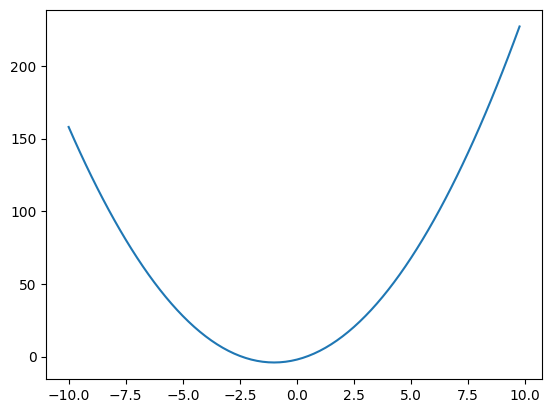

In [6]:
plt.plot(x_vals, y_vals)

In [7]:
# Finding slope
h = 0.0000000000001 # h is tending to 0
x = 5
slope = (func(x + h) - func(x)) / h
print(slope)

24.016344468691386


In [8]:
# Calculating partial derivatives
h = 0.0000000001

# inputs
a = 2.0
b = -7.0
c = 4.0

# Expression: a*b + c

inp = [a, b, c]
for i in range(len(inp)):
    d1 = inp[0]*inp[1] + inp[2]
    inp[i] += h
    d2 = inp[0]*inp[1] + inp[2]
    print("\nd1", d1)
    print("d2", d2)
    print("slope", (d2 - d1)/h)

# The above can be verified if we do a partial derivation of the expression with respect to a, b and c respectively and putting the other values


d1 -10.0
d2 -10.0000000007
slope -7.000000579182597

d1 -10.0000000007
d2 -10.0000000005
slope 2.000000165480742

d1 -10.0000000005
d2 -10.0000000004
slope 1.000000082740371


In [63]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad         # Here we have used += because we have to accumulate the gradient. If we use =, then the gradient will be overwritten in the case when we use the same variable in multiple operations
            other.grad += 1.0 * out.grad
        
        out._backward = _backward
        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')


        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        
        out._backward = _backward
        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "Currently only supporting int and float"
        out = Value(self.data ** other, (self, ), f'**{other}')

        def _backward():
            self.grad += other * self.data**(other - 1) * out.grad
        out._backward = _backward
        return out
    
    def __rmul__(self, other):
        return self * other
    
    def __truediv__(self, other):
        return self * other**-1
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)
    
    def __radd__(self, other):
        return self + other
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        
        out._backward = _backward
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad        # Can also be math.exp(x) * out.grad
        
        out._backward = _backward
        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [10]:
a = Value(2.0)
b = Value(-7.0)
c = Value(4.0)
d = a * b + c
print(d)
print(d._prev)
print(d._op)

Value(data=-10.0)
{Value(data=-14.0), Value(data=4.0)}
+


In [11]:
# Visualize the operations
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR -> Left to right
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name=uid, label="{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # create an op node if this value is a result of some operation
            dot.node(name=uid+n._op, label=n._op)
            # and connect this node to it
            dot.edge(uid+n._op, uid)
    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2))+n2._op)
    
    return dot

In [12]:
a = Value(2.0, label='a')
b = Value(-7.0, label='b')
c = Value(4.0, label='c')
e = a*b; e.label='e'
d = e+c; d.label='d'
f = Value(-2.0, label='f')
L = d*f; L.label='L'
L

Value(data=20.0)

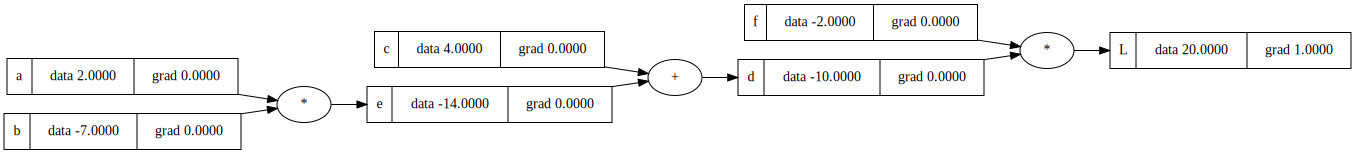

In [17]:
draw_dot(L)

In [14]:
# Now, we need to calculate the derivative of L w.r.t. every other variable such as a, b, e, c, f, d.
# This is nothing but calculating the gradient. The initial value of `grad` is 0 because it is assumed that at initialization,
# the variables (let us say a) does not have an effect on the output, i.e., changing this variable is not changing the loss function

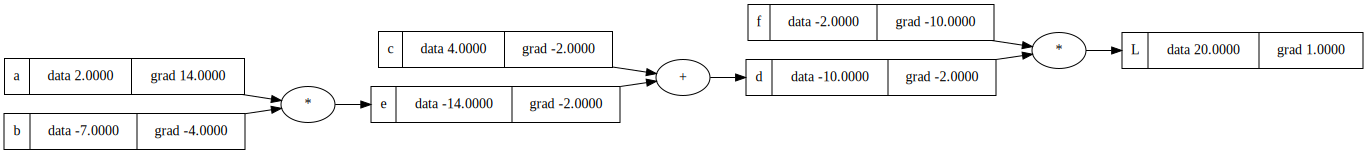

In [20]:
# Doing backpropogation manually
# Derivative of L w.r.t. L (if I change L, how much does L change?): The change is proportional, so derivative will be 1
L.grad = 1.0
draw_dot(L)

L = d * f

$\frac{\partial L}{\partial d} = ?$

$\frac{\partial L}{\partial d} = \frac{[f(x+h) - f(x)]}{h} = \frac{[(d+h) * f] - d*f}{h} = \frac{d*f + h*f - d*f}{h} = f$ \
So, $\frac{\partial L}{\partial d} = f$

Symmetrically,
$\frac{\partial L}{\partial f} = d$

So, \
`f.grad = d = -10.0` \
`d.grad = f = -2.0`

Now, we need to find dL/dc \
$\frac{\partial L}{\partial c} = \frac{\partial L}{\partial d} \times \frac{\partial d}{\partial c}$ (Basically, what we are doing here is calculating the effect of `c` on `L` through `d`)

$\frac{\partial L}{\partial c} = f \times \frac{\partial (e + c)}{\partial c} = f \times [\frac{\partial e}{\partial c} + \frac{\partial c}{\partial c}] = f \times [0 + 1]$

So, $\frac{\partial L}{\partial c} = f$\
Similalry, $\frac{\partial L}{\partial e} = \frac{\partial \{e+c\}*f}{\partial e} = \frac{\partial (ef + cf)}{\partial e} = f$

So, \
`c.grad = f = -2.0` \
`e.grad = f = -2.0`

Now, we need to find dL/da \
$\frac{\partial L}{\partial a} = \frac{\partial (d*f)}{\partial a} = \frac{\partial \{e+c\}*f}{a} = \frac{\partial \{(a*b)+c\}*f}{a} = \frac{\partial (abf + cf)}{a} = bf$
Similalry, $\frac{\partial L}{b} = af$

So, \
`a.grad = b*f = 14.0` \
`b.grad = a*f = -4.0`

In [19]:
f.grad = -10.0
d.grad = -2.0

c.grad = -2.0
e.grad = -2.0

a.grad = -7.0 * -2.0
b.grad = 2.0 * -2.0


In [21]:
def check():

    h = 0.01

    a = Value(2.0, label='a')
    b = Value(-7.0, label='b')
    c = Value(4.0, label='c')
    e = a*b; e.label='e'
    d = e+c; d.label='d'
    f = Value(-2.0, label='f')
    L = d*f; L.label='L'
    L1 = L.data

    a = Value(2.0, label='a')
    b = Value(-7.0+h, label='b')
    c = Value(4.0, label='c')
    e = a*b; e.label='e'
    d = e+c; d.label='d'
    f = Value(-2.0, label='f')
    L = d*f; L.label='L'
    L2 = L.data

    print((L2 - L1)/h)

check()

-3.9999999999999147


In [22]:
# Now to see it in action, we can nudge our inputs (the leaf nodes, because we usually have control over them) and see the effect of that on L
a.data += 0.01 * a.grad # increase in the direction of gradient
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

# Rerunning the forward pass
e = a * b
d = e + c
L = d * f

print(L.data)

23.279760000000003


## Making a Neuron

![image.png](https://miro.medium.com/v2/resize:fit:1318/0*ULAZWFmhB8hOMGBy.jpeg)

In [42]:
#inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

#weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(8, label='b')
x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label='n'
o = n.tanh(); o.label='o' # Adding the activation function on top of it

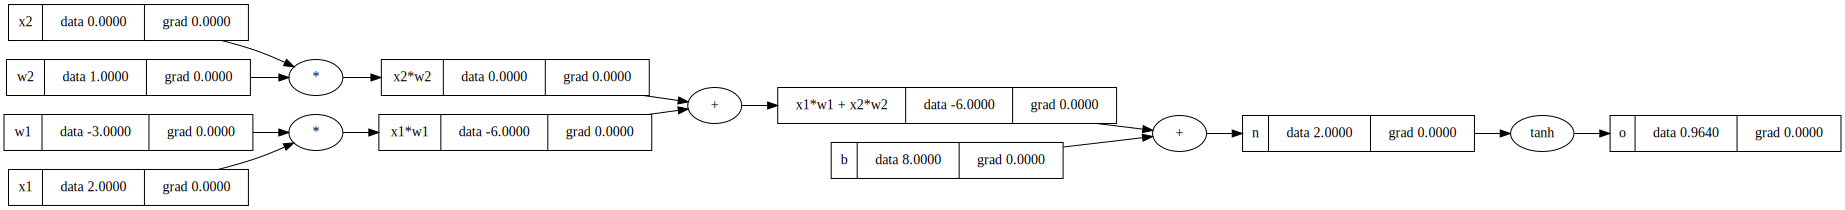

In [35]:
draw_dot(o)

In [28]:
# Base case (Same logic as previous)
# Derivative of o w.r.t. o (if I change o, how much does o change?): The change is proportional, so derivative will be 1
o.grad = 1.0

In [30]:
# Instead of doing the backpropogation manually, now we can just call the _backward method for each node.
# We still need the base case from the above cell, because in the class, we are assuming that the grad is 0 at the beginning 
o._backward()
n._backward()
b._backward() # Since `b` does not have anything before it (it is a leaf node), it will not have any effect on the gradient of the previous nodes
x1w1x2w2._backward()
x2w2._backward()
x1w1._backward()

In [36]:
# Now we need to automate calling the _backward method for each node also.
# This can be done by creating a function that will traverse the graph in reverse order and call the _backward method for each node
# And this can be achieved by something known as a topological sort. This is a way to sort the nodes in a graph such that if there is an edge from node A to node B, then A will come before B in the sorted order
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)

# So essentially what this function does is that it is ensuring that the output node (o) is only going to add itself to the `topo` list after all its children have added themselves to the `topo` list

build_topo(o)

In [37]:
# Base case
o.grad = 1.0

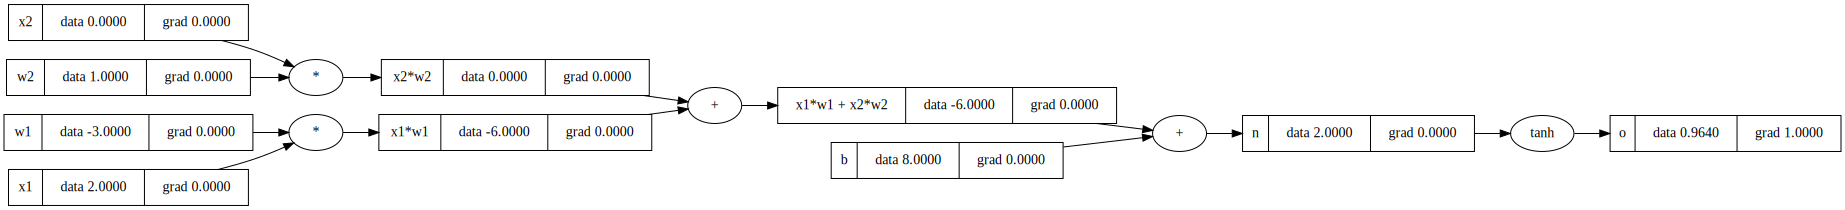

In [38]:
draw_dot(o) # Gradients initialized to 0

In [39]:
# Here in our example, we want to traverse from the output node to the input nodes, so that we can call the _backward method for each node in the correct order
for node in reversed(topo):
    node._backward()

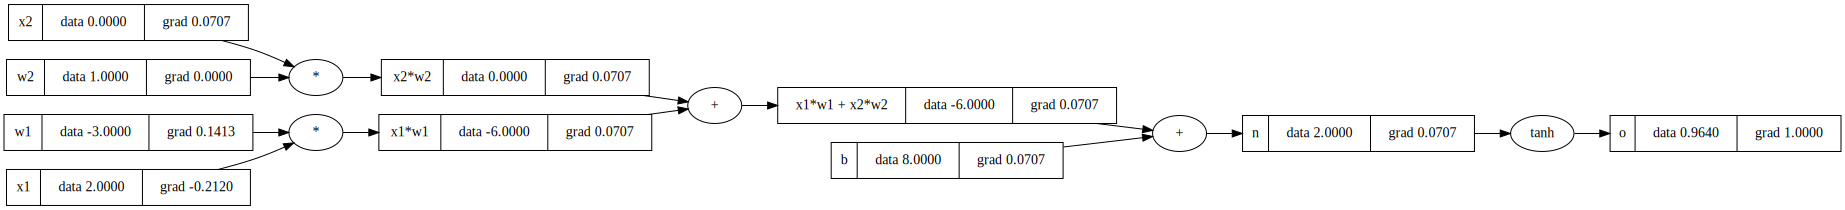

In [40]:
draw_dot(o) # Gradients updated

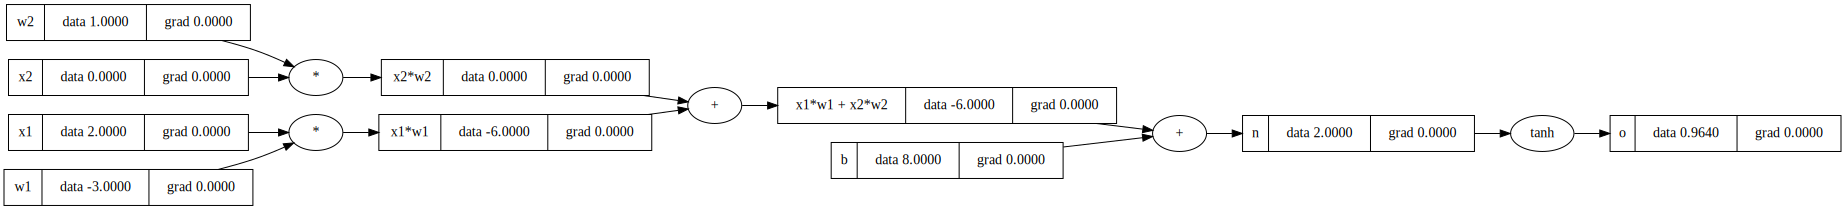

In [44]:
# Now we can actually hide the topological sort function in our Value class itself
# At this point, go and check the same implementation in the Value class
# Rerun the neuron cell and see if the gradients are initially 0
draw_dot(o)

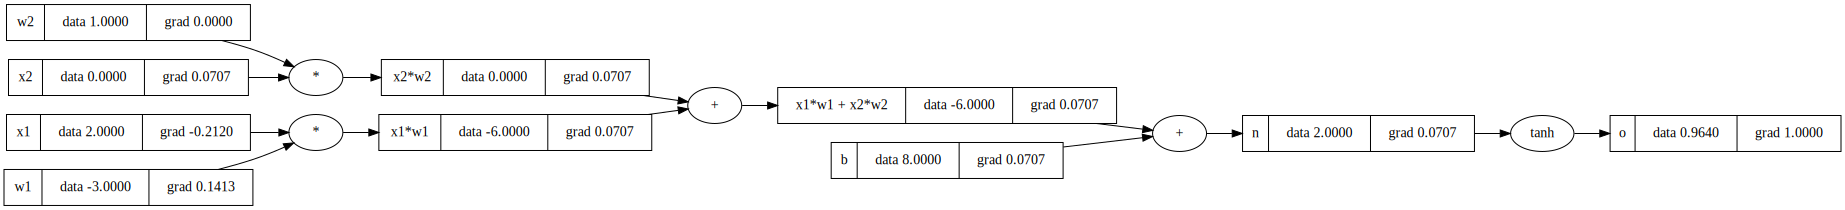

In [45]:
# Now we can directly call the backward() method on the output node
o.backward()
draw_dot(o)

#### Breaking the `tanh` function into its constituent operations

In [52]:
#inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

#weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(8, label='b')
x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label='n'
# -----
# o = n.tanh(); o.label='o'
e = (2*n).exp(); e.label = 'e'
o = (e - 1) / (e + 1); o.label = 'o'
# -----
o.backward()

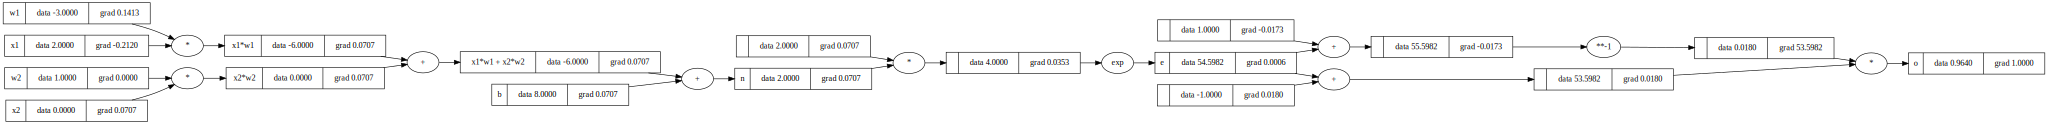

In [54]:
draw_dot(o)
# The gradients are coming out to be the same as the previous case when tanh was not split into its constituent operations

## Implementing The Same Using PyTorch

In [55]:
import torch

In [69]:
x1 = torch.Tensor([2.0]).double()       ; x1.requires_grad = True       # requires_grad is a flag that tells PyTorch to keep track of the gradient of this variable. By default it is False for leaf nodes for efficiency reasons
x2 = torch.Tensor([0.0]).double()       ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()      ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()       ; w2.requires_grad = True
b = torch.Tensor([8.0]).double()        ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())    # Forward pass
o.backward()            # Backward pass

print("----")
print('x1', x1.grad.item())     # Gradients of the input nodes
print('w1', w1.grad.item())
print('x2', x2.grad.item())
print('w2', w2.grad.item())

# We get the same values. So PyTorch agrees with us

0.9640275800758169
----
x1 -0.2119524745594933
w1 0.14130164970632886
x2 0.07065082485316443
w2 0.0


## Building a Neural Nets Piece by Piece (2-Layer Perceptron)

In [98]:
import random

In [144]:
class Neuron:
    def __init__(self, nin):    # nin is the number of inputs coming to a neuron
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))
    
    def __call__(self, x):
        # w * x + b
        activation = sum((wi*xi for wi, xi, in zip(self.w, x)), self.b)
        out = activation.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [206]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.13264841070802572)

In [207]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

ys = [1.0, -1.0, -1.0, 1.0]

In [214]:
for k in range(20):
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

    # backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()

    # update weights
    for p in n.parameters():
        p.data += -0.1 * p.grad
    
    print(k, loss.data)

0 0.00418532219096804
1 0.004116303766678124
2 0.004049437911466803
3 0.003984627230684686
4 0.003921780057225848
5 0.003860810039516563
6 0.003801635764387294
7 0.0037441804114433123
8 0.0036883714359182106
9 0.003634140277319579
10 0.00358142209146135
11 0.003530155503730091
12 0.0034802823816549528
13 0.0034317476250486775
14 0.003384498972161772
15 0.0033384868204474807
16 0.0032936640606737503
17 0.0032499859232404003
18 0.0032074098356712644
19 0.003165895290347162


In [215]:
ypred

[Value(data=0.9781181948310983),
 Value(data=-0.9836303223211579),
 Value(data=-0.9678880323880789),
 Value(data=0.962744972397284)]